In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import copy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

plt.style.use('seaborn')

!pwd

/Users/feliperuiz/Desktop/github/stackage-evolution/notebooks


In [2]:
lts_list = [
    '0-7', 
    '2-22',
    '3-22',
    '6-35',
    '7-24',
    '9-21',
    '11-22',
    '12-14',
    '12-26',
    '13-11',
    '13-19',
    '14-27',
    '15-3',
    '16-11',
    '16-22'
]

df_list = []

df_by_category_list = []

path = '/Users/feliperuiz/Desktop/github/stackage-evolution/notebooks'

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# Evolucion del ecosistema de Haskell

### 1. ¿Cuales son los paquetes más utilizados actualmente?: 

Hacer un map (KEY-VALUE) con todas las dependencias del ultima version LTS, en donde la KEY sera el nombre del paquete y el VALUE sera la cantidad de veces que fue requerido.

In [60]:
def get_current_top_used_packages():
    pkgs = {}
    
    for i, row in df_list[14].iterrows():        
        for dependency in (list(set(row['deps']))):
            if(not dependency in pkgs):
                pkgs[dependency] = 1
            else:
                pkgs[dependency] += 1
    
    return pkgs

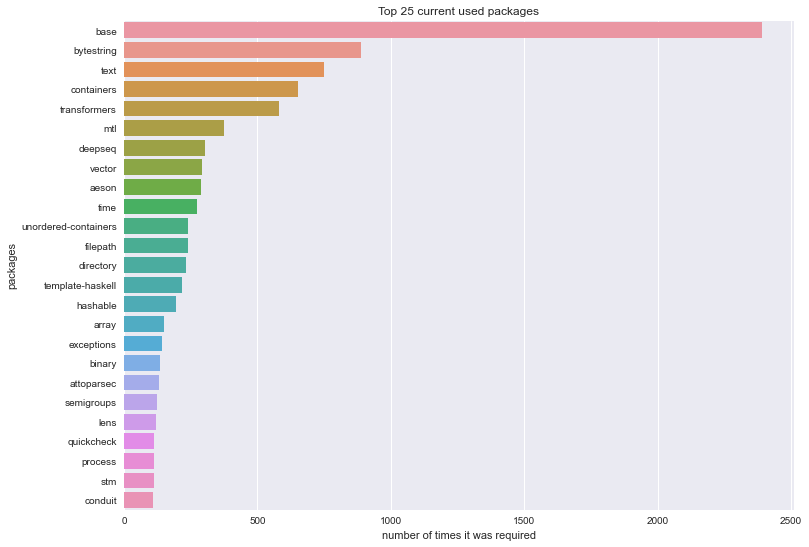

In [61]:
top_25_pkgs = []
top_25_count = []

count_used = get_current_top_used_packages()
ordered_pkgs = sorted(count_used, key=count_used.get, reverse=True)[:25]

for pkg in ordered_pkgs:
    top_25_pkgs.append(pkg)
    top_25_count.append(count_used[pkg])
    
top_25_df = pd.DataFrame(data={'package': top_25_pkgs, 'count_deps': top_25_count })
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(y="package", x="count_deps", data=top_25_df, orient='h') 
ax.set_title('Top 25 current used packages')
ax.set_ylabel('packages')
ax.set_xlabel('number of times it was required')
plt.show()

### 2. ¿Cuales de los paquetes mas utilizados estan fuera de la seleccion?:

Obtener un listado de todos los paquetes que fueron partes de Stackage en alguna version LTS. Filtrar el map de dependencias anterior con la lista retornando solo aquellos paquetes que no se encuentren en la lista.

In [19]:
def get_packages_out_of_stackage(pkgs):
    all_pkgs = list(df_list[14]['package'])
    return list(filter(lambda pkg: pkg not in all_pkgs, pkgs))

In [67]:
top = get_current_top_used_packages()
top = sorted(top, key=top.get, reverse=True)[:100]
get_packages_out_of_stackage(top)

['quickcheck', 'microlens', 'hunit', 'cabal']

### 3. ¿Cuantos transitivamente quedan fuera de stackage? (Cuantos dependenden transitivamente de paquetes que no estan en la seleccion?

In [21]:
def check(df, pkg, pkgs_out_stackage):
    print(f"checking {pkg}")
    
    # Si el paquete no esta en la version LTS retorna True (Queda transitivamente fuera de stackage)
    if not pkg in list(df['package']):
        pkgs_out_stackage.append(pkg)
        return True
    
    for dependency in df[df['package'] == pkg]['deps'][0]:
        return check(df, dependency, pkgs_out_stackage)

    return False

In [22]:
from api import get_all_time_packages
lista = get_all_time_packages(df_list)
if 'alarmclock' in lista:
    print("si esta")

si esta


In [32]:
visited = {}

def dfs(lts, pkg):
    visited[pkg] = True
    
    if not pkg in list(df['package']):
        return False
    
    for dependency in df[df['package'] == pkg]['deps'][0]:
        if visited[pkg] != True:
            dfs(dependency)
    
    return True


out_transitive_pkgs = create_lts_obj()

for i, df in enumerate(df_list):
    visited = {}
    aux_out_transitive_pkgs = []
    pkgs_out_stackage = []
    
    for idx, row in df.iterrows():    
        for dependency in (list(set(row['deps']))):
            if not dfs(lts_list[i], dependency):
                aux_out_transitive_pkgs.append(row['package']) 
    
    print(f"{lts_list[i]} procesed")
    out_transitive_pkgs[lts_list[i]] = len(set(aux_out_transitive_pkgs))
    
out_transitive_pkgs

0-7 procesed
2-22 procesed
3-22 procesed
6-35 procesed
7-24 procesed
9-21 procesed
11-22 procesed
12-14 procesed
12-26 procesed
13-11 procesed
13-19 procesed
14-27 procesed
15-3 procesed
16-11 procesed
16-22 procesed


{'0-7': 101,
 '2-22': 141,
 '3-22': 201,
 '6-35': 344,
 '7-24': 359,
 '9-21': 414,
 '11-22': 385,
 '12-14': 349,
 '12-26': 349,
 '13-11': 345,
 '13-19': 339,
 '14-27': 388,
 '15-3': 343,
 '16-11': 378,
 '16-22': 404}

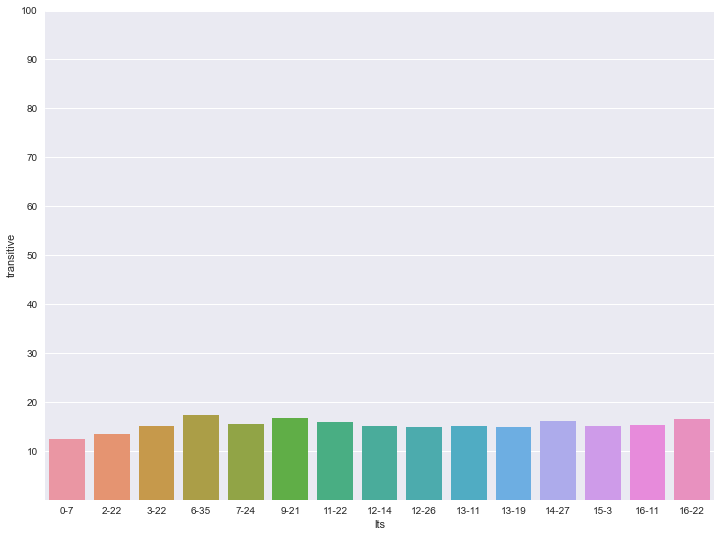

In [34]:
per_transitive = {}
for idx, lts in enumerate(out_transitive_pkgs):
    per_transitive[lts] = out_transitive_pkgs[lts]*100 / len(df_list[idx])
    
df = pd.DataFrame(data={'lts': list(per_transitive.keys()), 'transitive': list(per_transitive.values()) })
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(y="transitive", x="lts", data=df) 
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

In [55]:
import statistics
statistics.mean(list(per_transitive.values()))

15.27762398684246

### 4. ¿Que tan frecuente se actualizan los paquetes? (¿cuantificar la cantidad de paquetes que actualizaron su version?, ¿Acumulado hasta cada version?)) 

In [25]:
from api import get_versions_df
versions_df = get_versions_df(df_list)
versions_df

,0-7,2-22,3-22,6-35,7-24,9-21,11-22,12-14,12-26,13-11,13-19,14-27,15-3,16-11,16-22
btrfs,,,0.1.1.1,0.1.2.3,0.1.2.0,0.1.2.3,0.1.2.3,0.1.2.3,0.1.2.3,0.2.0.0,0.2.0.0,0.2.0.0,0.2.0.0,0.2.0.0,0.2.0.0
ViennaRNAParser,,,,1.2.9,1.2.9,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3,1.3.3
wave,,,,,0.1.5,0.1.5,0.1.5,0.1.5,0.1.5,0.1.5,0.1.5,0.2.0,0.2.0,0.2.0,0.2.0
ghc-mtl,1.2.1.0,1.2.1.0,1.2.1.0,1.2.1.0,,,,,,,,,,,
gtk,0.13.4,0.13.9,0.13.9,0.14.2,0.14.6,0.14.7,,0.14.10,0.14.10,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
network-messagepack-rpc-websocket,,,,,,,,,,,,,,0.1.1.1,0.1.1.1
opentelemetry-lightstep,,,,,,,,,,,,,,0.4.2,0.4.2
xmonad,,,,0.12,0.12,0.13,0.13,,,0.15,0.15,0.15,0.15,0.15,0.15
eventsource-geteventstore-store,,,,,,,1.1.0,,,,,,,,


In [26]:
def last_update(row):
    for value in reversed(row):
        if isinstance(value, int) and value >= 0:
            return value
        
    return -1

In [27]:
def was_updated(version_list, version, idx):
    if idx == 0:
        return True
    
    for past_version in reversed(version_list[:idx]):
        if version != "":
            return past_version != version 
            
    return False

In [28]:
from api import get_all_time_packages
pkgs = get_all_time_packages(df_list)
df = pd.DataFrame(index=pkgs, columns=lts_list)

for i, row in df.iterrows():
    row_versions = versions_df[versions_df.index == row.name].values[0]
    
    for idx, version in enumerate(row_versions):
        if version == "":
            row.values[idx] = -1
            continue
        
        last_value = last_update(row.values)
        row.values[idx] = last_value + 1 if was_updated(row_versions, version, idx) else last_value
    
df = df.replace(-1, 0)

df.head(10)

,0-7,2-22,3-22,6-35,7-24,9-21,11-22,12-14,12-26,13-11,13-19,14-27,15-3,16-11,16-22
btrfs,0,0,0,1,2,3,3,3,3,4,4,4,4,4,4
ViennaRNAParser,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
wave,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
ghc-mtl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gtk,0,1,1,2,3,4,0,5,5,0,0,0,0,0,0
type-eq,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
yamlparse-applicative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
hasmin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
text-short,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
amazonka-dynamodb,0,0,0,1,1,2,3,3,3,4,4,0,5,5,5


In [29]:
def create_lts_obj():
    data = {}
    for idx, lts in enumerate(lts_list):
        data[lts] = []
    return data

In [30]:
count_updated_packages_by_lts = create_lts_obj()

for idx, lts in enumerate(lts_list):
    count_updated_packages_by_lts[lts] = 0
    if idx == 0:
        count_updated_packages_by_lts[lts] = 0
        continue
    
    for i, actual_version in enumerate(df[lts]):
        pkg = df.iloc[i].name
        last_version = df[lts_list[idx-1]].iloc[i]
        
        if actual_version == last_version+1:
            count_updated_packages_by_lts[lts] += 1

            

print(count_updated_packages_by_lts)
for idx, lts in enumerate(count_updated_packages_by_lts):
    count_updated_packages_by_lts[lts] = count_updated_packages_by_lts[lts]*100 / len(df_list[idx])

{'0-7': 0, '2-22': 449, '3-22': 383, '6-35': 720, '7-24': 295, '9-21': 966, '11-22': 999, '12-14': 502, '12-26': 151, '13-11': 492, '13-19': 124, '14-27': 759, '15-3': 318, '16-11': 503, '16-22': 165}


['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11', '16-22']
[0.0, 42.88443170964661, 28.883861236802414, 36.400404448938325, 12.693631669535284, 39.046079223928864, 41.02669404517454, 21.572840567253976, 6.4310051107325386, 21.597892888498684, 5.4077627562145665, 31.389578163771713, 14.008810572687224, 20.447154471544714, 6.7182410423452765]


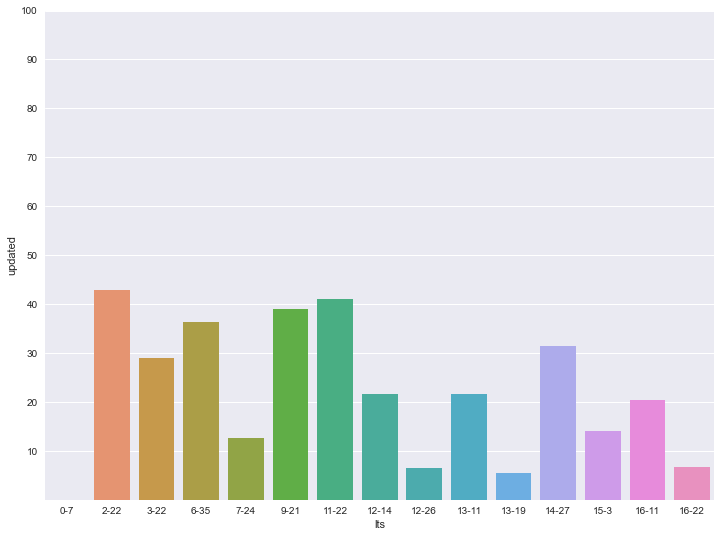

In [31]:
print(list(count_updated_packages_by_lts.keys()))
print(list(count_updated_packages_by_lts.values()))

df = pd.DataFrame(data={
    'lts': list(count_updated_packages_by_lts.keys()), 
    'updated': list(count_updated_packages_by_lts.values())
})
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(y="updated", x="lts", data=df) 
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

# Evolucion del uso de monadas por los desarrolladores

### 5. ¿Como se distribuye mtl en stackage en terminos de meta-data?: 

- SELECIONAR GRAFICOS QUE USAREMOS

### 6. ¿Que porcentaje de paquetes utilizan mtl a lo largo del tiempo?

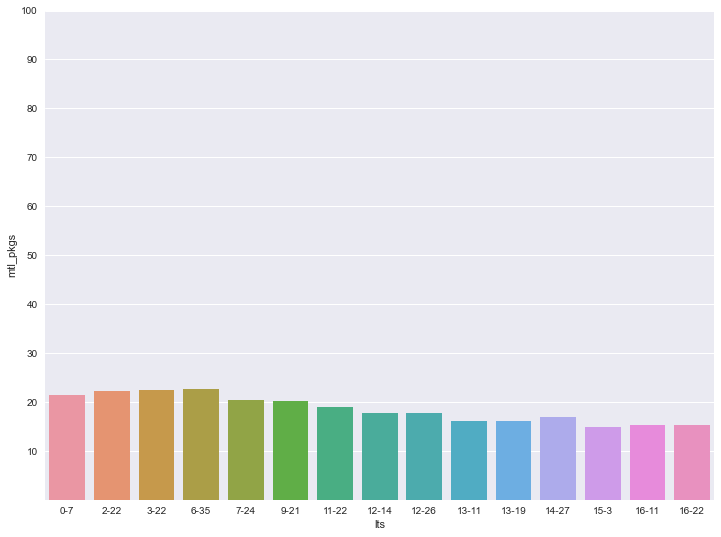

In [35]:
per_mtl_pkgs = create_lts_obj()

for idx, df in enumerate(df_list):
    percentage = len(df[df['mtl-direct'] == 1]) * 100 / len(df)
    per_mtl_pkgs[lts_list[idx]] = percentage

df = pd.DataFrame(data={'lts': list(per_mtl_pkgs.keys()), 'mtl_pkgs': list(per_mtl_pkgs.values()) })
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(y="mtl_pkgs", x="lts", data=df)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

In [51]:
import statistics
statistics.mean(list(per_mtl_pkgs.values()))
per_mtl_pkgs.values()

dict_values([21.349693251533743, 22.1585482330468, 22.473604826546, 22.598584428715874, 20.395869191049915, 20.129345189975748, 18.93223819301848, 17.66222604211431, 17.717206132879046, 16.154521510096576, 16.179677278674227, 16.95616211745244, 14.933920704845814, 15.24390243902439, 15.268729641693811])

### 7. ¿Como crecio la cantidad de paquetes que usan monadas frente a la cantidad de paquetes que dejaron de utilizarlas en el tiempo? (EN TERMINOS TOTALES???)

In [36]:
def build_mtl_continuity_matrix(index):
    df = pd.DataFrame(index=index, columns=lts_list)

    for i, row in df.iterrows():
        for j, lts in enumerate(lts_list):
            state = 0
            package = df_list[j].loc[df_list[j]['package'].isin([row.name])]

            if(not package.empty):
                state = 1
                [use_mtl] = package['mtl-direct'].values
                if(use_mtl == 1):
                    state = 2
            
            df.at[row.name, lts] = float(state)

    for idx, lts in enumerate(lts_list):
            df[lts] = pd.to_numeric(df[lts]) 
            
    return df

In [37]:
from api import get_all_time_packages
mtl_continuity_df = build_mtl_continuity_matrix(get_all_time_packages(df_list))

In [38]:
def get_added_packages_mtl_by_lts(continuity_df):
    count = list(np.zeros(len(lts_list)))

    for i, row in continuity_df.iterrows():
        for j, lts in enumerate(lts_list):
            if(row[lts] == 2):
                if(j == 0):
                    count[j] += 1
                elif(row[j-1] < 2):
                    count[j] += 1
    
    return count

def get_removed_packages_mtl_by_lts(continuity_df):
    count = list(np.zeros(len(lts_list)))
    
    for i, row in continuity_df.iterrows():
        for j, lts in enumerate(lts_list):
            if(j > 0):
                if((row[j] == 1 or row[j] == 0) and row[j-1] == 2):
                    count[j] += 1
    return count

In [39]:
added_mtl_pkgs_count = get_added_packages_mtl_by_lts(mtl_continuity_df)
removed_mtl_pkgs_count = get_removed_packages_mtl_by_lts(mtl_continuity_df)
total = []

for idx, lts in enumerate(lts_list):
    total.append(added_mtl_pkgs_count[idx] - removed_mtl_pkgs_count[idx])
    

mtl_count_continuity_df = pd.DataFrame(data={
    'lts': lts_list, 
    'added_mtl_pkgs_count': added_mtl_pkgs_count, 
    'removed_mtl_pkgs_count': removed_mtl_pkgs_count,
    'total': total
})

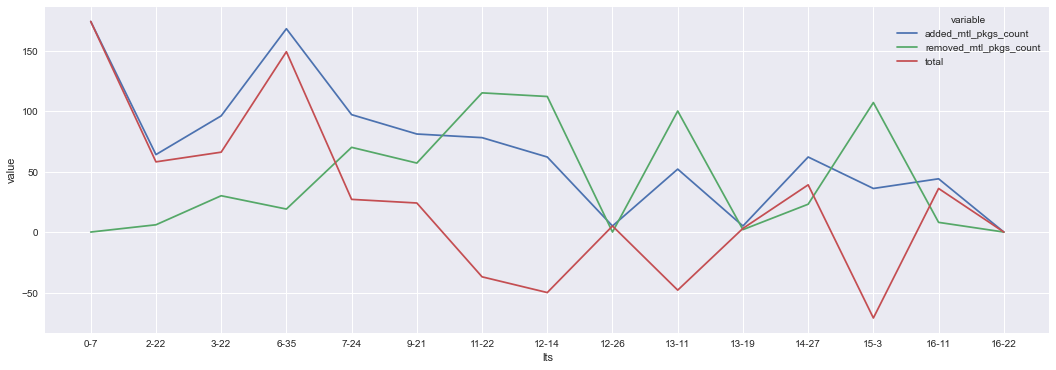

In [40]:
plt.figure(figsize=(18,6))
sns.lineplot(x='lts', y='value', hue='variable', data=pd.melt(mtl_count_continuity_df, ['lts']))

plt.savefig("graphs/added_removed_mlt_packages.png", bbox_inches='tight')
plt.show()

### 8. ¿Que paquetes que ya usaban monadas en sus futuras versiones dejaron de usarlas? (en porcentaje (en categoria) y ) ¿en cada version cuantas dejaron de utilzar mtl?)

- Nacieron usando mtl y dejaron de usar mtl pero se mantuvieron en la selección
- Nacieron sin usar mtl y comenzaron a utilizar mtl en el futuro